# Corona and Fly Spread 2019-2020

The aim of this notebook is to track the spread of Corona virus vs seasonal flu.

Todo:

- Find flu database

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
#url = "https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-2020-03-22.xlsx"
file = "COVID-19-geographic-disbtribution-worldwide-2020-03-22.xlsx"
db = pd.read_excel(file, usecols=[0,4,5,6], converters= {'DateRep': pd.to_datetime})
db.rename(columns={"Countries and territories": "Country"}, inplace=True, errors="raise")
db.rename(columns={"DateRep": "Date"}, inplace=True, errors="raise")
db.rename(columns={"Deaths": "Dead"}, inplace=True, errors="raise")
db.rename(columns={"Cases": "Cases"}, inplace=True, errors="raise")
db.sort_values('Date', inplace=True)
db["Deadsum"] = db.groupby(by=['Country']).cumsum().Dead

# read country population database
population = pd.read_html("https://en.wikipedia.org/wiki/List_of_countries_by_population_(United_Nations)")[1]
population.drop(columns=[1,2,3,5], inplace=True)
population = population.rename(columns={0: "Country", 4: "Population"}).dropna()
population["Country"] = population["Country"].replace(to_replace="China[a]", value="China")
population["Country"] = population["Country"].replace(to_replace="Spain[d]", value="Spain")

# merge the two databases above
db = pd.merge(db, population, on="Country")
db.Population = db["Population"].astype(int).values
db["dead_per_million"] = db.Deadsum / db.Population * 1e6
db

,Date,Cases,Dead,Country,Deadsum,Population,dead_per_million
0,2019-12-31,0,0,Singapore,0,5804337,0.0
1,2020-01-01,0,0,Singapore,0,5804337,0.0
2,2020-01-02,0,0,Singapore,0,5804337,0.0
3,2020-01-03,0,0,Singapore,0,5804337,0.0
4,2020-01-04,0,0,Singapore,0,5804337,0.0
...,...,...,...,...,...,...,...
4348,2020-03-21,1,0,Niger,0,23310715,0.0
4349,2020-03-22,0,0,Niger,0,23310715,0.0
4350,2020-03-22,2,0,Angola,0,31825295,0.0
4351,2020-03-22,1,0,Eritrea,0,3497117,0.0


In [8]:
denmark = db["Country"] == "Denmark"
sweden = db["Country"] == "Sweden"
denmark = db["Country"] == "Denmark"
iran = db["Country"] == "Iran"
italy = db["Country"] == "Italy"
china = db["Country"] == "China"
spain = db["Country"] == "Spain"
db[sweden]

,Date,Cases,Dead,Country,Deadsum,Population,dead_per_million
2215,2019-12-31,0,0,Sweden,0,10036379,0.000000
2216,2020-01-01,0,0,Sweden,0,10036379,0.000000
2217,2020-01-02,0,0,Sweden,0,10036379,0.000000
2218,2020-01-03,0,0,Sweden,0,10036379,0.000000
2219,2020-01-04,0,0,Sweden,0,10036379,0.000000
...,...,...,...,...,...,...,...
2293,2020-03-18,46,1,Sweden,8,10036379,0.797100
2294,2020-03-19,134,2,Sweden,10,10036379,0.996375
2295,2020-03-20,122,0,Sweden,10,10036379,0.996375
2296,2020-03-21,200,6,Sweden,16,10036379,1.594200


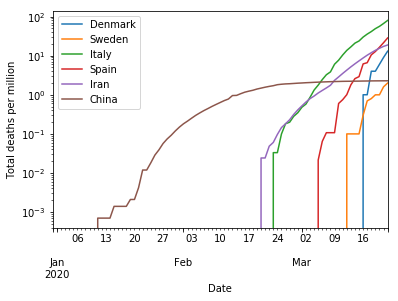

In [7]:
denmark = db["Country"] == "Denmark"
sweden = db["Country"] == "Sweden"
ax = db[denmark].plot(x="Date", y="Deadsum", label="Denmark")
db[sweden].plot(x="Date", y="dead_per_million", ax=ax, label="Sweden")
db[italy].plot(x="Date", y="dead_per_million", ax=ax, label="Italy")
db[spain].plot(x="Date", y="dead_per_million", ax=ax, label="Spain")
db[iran].plot(x="Date", y="dead_per_million", ax=ax, label="Iran")
db[china].plot(x="Date", y="dead_per_million", ax=ax, label="China")
ax.set_ylabel("Total deaths per million")
ax.set_xlabel("Date")
ax.set_yscale('log')